In [1]:
!python -m pip install pyyaml
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.engine import DefaultPredictor
# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

import torch


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

matplotlib data path: /home/ghostfish/Downloads/python_control_homework/lib/python3.12/site-packages/matplotlib/mpl-data
CONFIGDIR=/home/ghostfish/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/home/ghostfish/.cache/matplotlib
Using fontManager instance from /home/ghostfish/.cache/matplotlib/fontlist-v390.json


In [3]:

%cd /home/ghostfish/Downloads/python_control_homework/dataset

/home/ghostfish/Downloads/python_control_homework/dataset


In [4]:
%ls

DATASET_asparagas/  DATASET_balloon/  DATASET_kiwi/  detectron2/  output/


In [5]:

from detectron2.data.datasets import register_coco_instances
register_coco_instances("asparagas_train", {}, "/home/ghostfish/Downloads/python_control_homework/dataset/DATASET_asparagas/train/annotation_train.json", "/home/ghostfish/Downloads/python_control_homework/dataset/DATASET_asparagas/train")

#register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/COLAB_CODES/DATASET_kiwi/valid/_annotations.coco.json", "/content/drive/MyDrive/COLAB_CODES/DATASET_kiwi/valid")
#register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/COLAB_CODES/DATASET_kiwi/test/_annotations.coco.json", "/content/drive/MyDrive/COLAB_CODES/DATASET_kiwi/test")


WARNING [06/11 21:12:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/11 21:12:09 d2.data.datasets.coco]: Loaded 14 images in COCO format from /home/ghostfish/Downloads/python_control_homework/dataset/DATASET_asparagas/train/annotation_train.json


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/ghostfish/Downloads/python_control_homework/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/ghostfish/Downloads/python_control_homework/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/ghostfish/Downloads/python_control_homework/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/ghostfish/Downloads/python_control_homework/

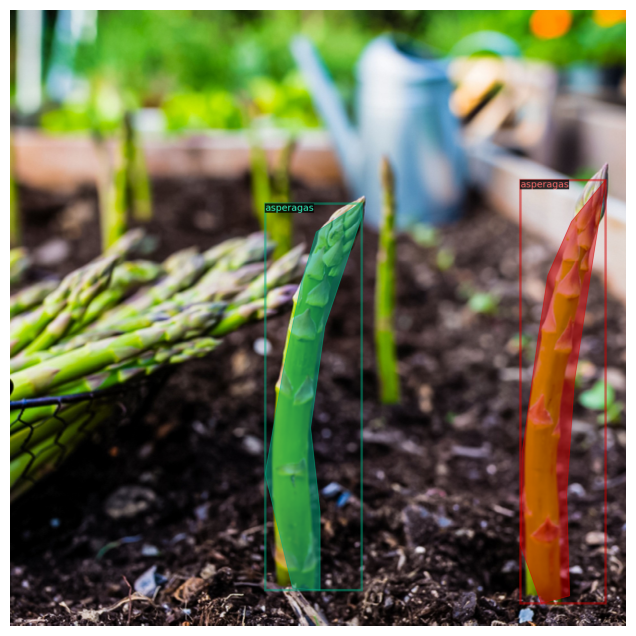

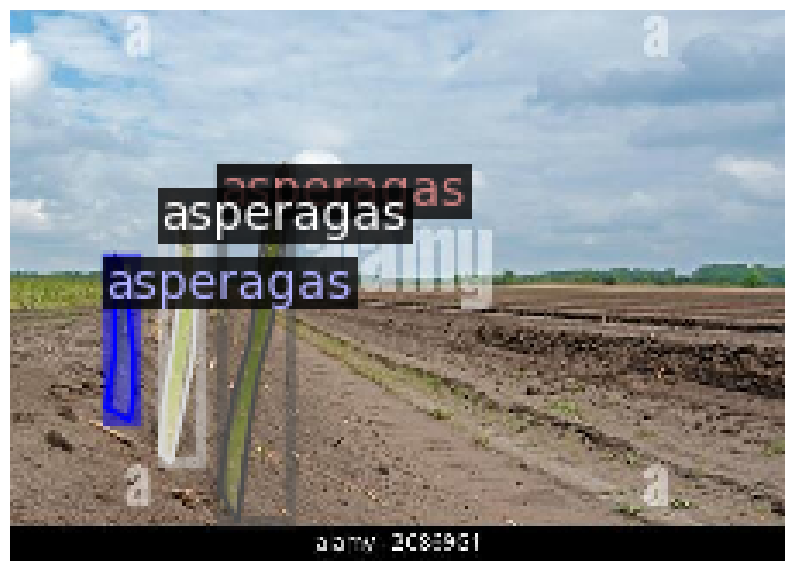

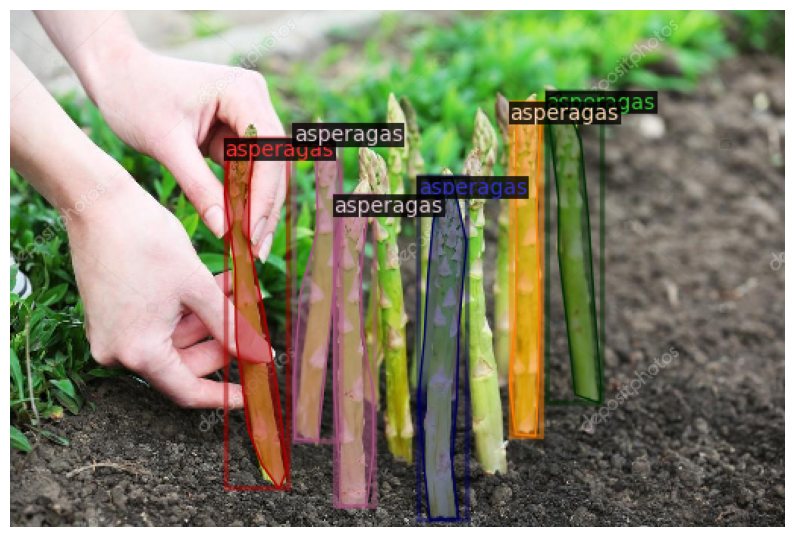

In [6]:
#visualize training data
asparagas_metadata = MetadataCatalog.get("asparagas_train")
dataset_dicts = DatasetCatalog.get("asparagas_train",)

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(os.path.join('DATASET_asparagas', d['file_name']))
    
    # Option 1 (Recommended)
    visualizer = Visualizer(img[:, :, ::-1], metadata=asparagas_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(vis.get_image())  # No conversion needed
    plt.axis('off')
    plt.show()

In [7]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("asparagas_train")
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = 'cuda'
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/11 21:12:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[06/11 21:12:12 d2.engine.train_loop]: Starting training from iteration 0
tag: XResolution (282) - type: rational (5) Tag Location: 22 - Data Location: 62 - value: b'\x00\x00\x01,\x00\x00\x00\x01'
tag: YResolution (283) - type: rational (5) Tag Location: 34 - Data Location: 70 - value: b'\x00\x00\x01,\x00\x00\x00\x01'
tag: ResolutionUnit (296) - type: short (3) - value: b'\x00\x02'
tag: YCbCrPositioning (531) - type: short (3) - value: b'\x00\x01'
tag: XResolution (282) - type: rational (5) Tag Location: 22 - Data Location: 74 - value: b'\x00\x00\x00H\x00\x00\x00\x01'
tag: YResolution (283) - type: rational (5) Tag Location: 34 - Data Location: 82 - value: b'\x00\x00\x00H\x00\x00\x00\x01'
tag: ResolutionUnit (296) - type: short (3) - value: b'\x00\x02'
tag: YCbCrPositioning (531) - type: short (3) - value: b'\x00\x01'
tag: Copyright (33432) - type: string (2) Tag Location: 70 - Data Location: 90 - value: <table: 37 bytes>


/home/ghostfish/Downloads/python_control_homework/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tag: XResolution (282) - type: rational (5) Tag Location: 22 - Data Location: 74 - value: b'\x00\x00\x00H\x00\x00\x00\x01'
tag: YResolution (283) - type: rational (5) Tag Location: 34 - Data Location: 82 - value: b'\x00\x00\x00H\x00\x00\x00\x01'
tag: ResolutionUnit (296) - type: short (3) - value: b'\x00\x02'
tag: YCbCrPositioning (531) - type: short (3) - value: b'\x00\x01'
tag: Copyright (33432) - type: string (2) Tag Location: 70 - Data Location: 90 - value: b'(c) Barmalini | Dreamstime.com\x00'
tag: ImageDescription (270) - type: string (2) Tag Location: 22 - Data Location: 26 - value: <table: 37 bytes>
tag: XResolution (282) - type: rational (5) Tag Location: 22 - Data Location: 62 - value: b'\x00\x00\x01,\x00\x00\x00\x01'
tag: YResolution (283) - type: rational (5) Tag Location: 34 - Data Location: 70 - value: b'\x00\x00\x01,\x00\x00\x00\x01'
tag: ResolutionUnit (296) - type: short (3) - value: b'\x00\x02'
tag: YCbCrPositioning (531) - type: short (3) - value: b'\x00\x01'
tag: XR

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/11 21:13:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[Checkpointer] Loading from ./output/model_final.pth ...


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='/home/ghostfish/Downloads/python_control_homework/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/ghostfish/Downloads/python_control_homework/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/ghostfish/Downloads/python_control_homework/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/ghostfish/Downloads/python_control_homework/

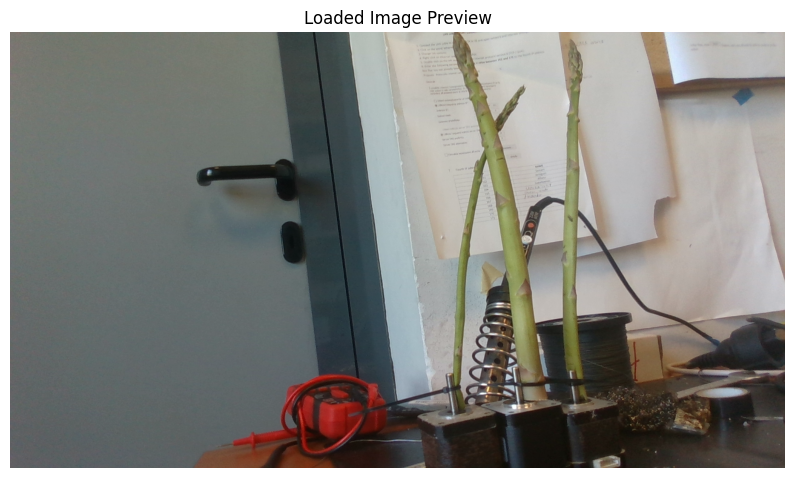

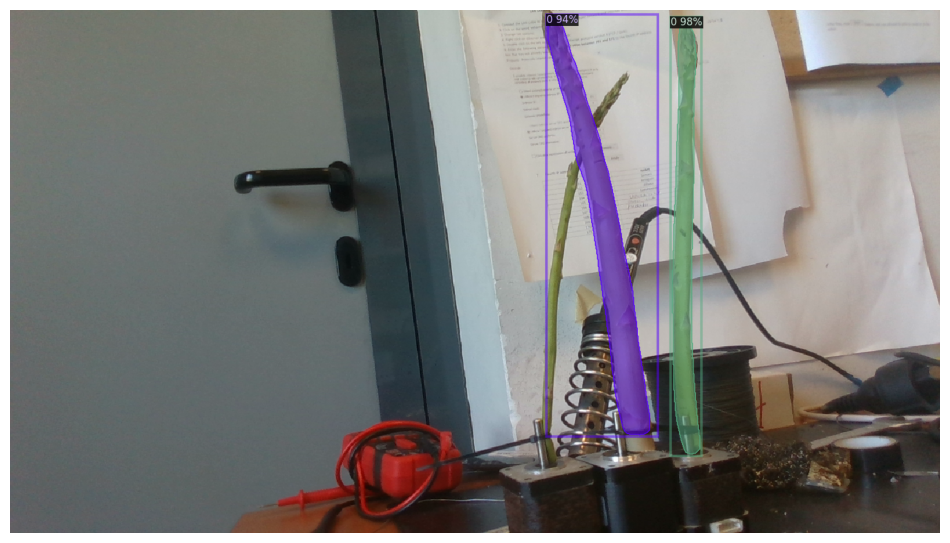

In [10]:
im = cv2.imread("/home/ghostfish/Downloads/python_control_homework/d435_Color.png")
# Check if image loaded successfully
if im is None:
    print("Error: Could not load image. Please check the file path.")
else:
    # Convert BGR to RGB for matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))  # Proper conversion
    plt.axis('off')  # Hide axes
    plt.title("Loaded Image Preview")
    plt.show()

outputs = predictor(im)

# Visualization - Proper color handling
v = Visualizer(im[:, :, ::-1],  # Convert BGR to RGB here
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display options:

# Option 1: For Jupyter/Colab with matplotlib (recommended)
plt.figure(figsize=(12, 8))
plt.imshow(out.get_image())  # Visualizer output is already RGB
plt.axis('off')
plt.show()



Mask saved as 'segmentation_mask.png'
Masked result saved as 'masked_result.jpg'


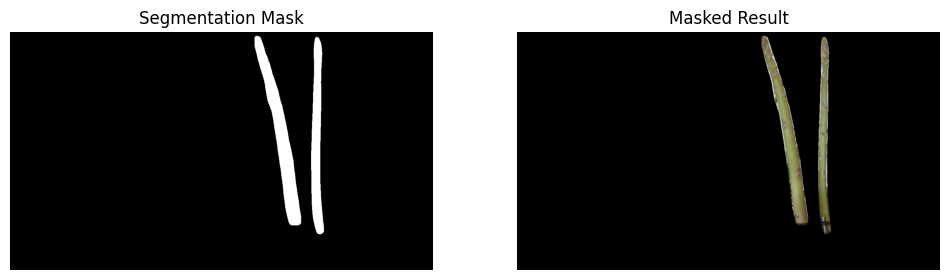

In [11]:
instances = outputs["instances"].to("cpu")

instances = outputs["instances"].to("cpu")

if len(instances) > 0:
    # Create combined mask (PyTorch tensor)
    combined_mask = instances.pred_masks.any(dim=0)  # Logical OR of all masks
    
    # Convert to numpy and scale to 0-255
    final_mask = (combined_mask.numpy() * 255).astype(np.uint8)
    
    # Apply mask to original image
    masked_image = cv2.bitwise_and(im, im, mask=final_mask)
    
    # Save the mask
    cv2.imwrite("segmentation_mask.png", final_mask)
    print("Mask saved as 'segmentation_mask.png'")
    
    # Save masked image (optional)
    cv2.imwrite("masked_result.jpg", cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    print("Masked result saved as 'masked_result.jpg'")
    
    # Visualize
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(final_mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.title("Masked Result")
    plt.axis('off')
    plt.show()

else:
    print("No objects detected - no mask created")
